In [48]:
# temp_rf.py
# initial author: Tim Currier; last updated: 2022-05-25
# saves numpy arrays and 2-color mp4 movies of the STRFs for all ROIs in a set
# array filter is 4 sec; movie of the first 2 sec at 1/2 real-time speed

# argumenmts: [1] date (yyyy-mm-dd); [2] series_number; [3] roi_set_name
# implementation: save_strfs.py 2022-03-17 1 roi_set_postfrom visanalysis.analysis import imaging_data, shared_analysis
from visanalysis.util import plot_tools
from visanalysis.analysis import imaging_data, shared_analysis
import matplotlib.pyplot as plt
import numpy as np
import os
from two_photon_analysis import medulla_analysis as ma
import sys
import cv2
import warnings
from tifffile import imsave
from pathlib import Path 
from scipy.ndimage import gaussian_filter

In [52]:
# define recording series to analyze
experiment_file_directory = '/Volumes/ROG2TBAK/data/bruker/20221025'
experiment_file_name = '2022-10-25' #sys.argv[1]
series_number = '1' #int(sys.argv[2])
roi_set_name = 'proximal_z2' #sys.argv[3]

# join path to proper format for ImagingDataObject()
file_path = os.path.join(experiment_file_directory, experiment_file_name + '.hdf5')
print(file_path)

# create save directory
save_directory = '/Volumes/ROG2TBAK/data/bruker/trfs' + experiment_file_name + '/'
Path(save_directory).mkdir(exist_ok=True)

# create ImagingDataObject (wants a path to an hdf5 file and a series number from that file)
ID = imaging_data.ImagingDataObject(file_path,
                                    series_number,
                                    quiet=True)

# get ROI timecourses and stimulus parameters
roi_data = ID.getRoiResponses(roi_set_name)
epoch_parameters = ID.getEpochParameters()
run_parameters = ID.getRunParameters()

/Volumes/ROG2TBAK/data/bruker/20221025/2022-10-25.hdf5


In [56]:
print(epoch_parameters)

[{'angle': 0, 'distribution_data': "{'name': 'Ternary', 'args': [], 'kwargs': {'rand_min': 0, 'rand_max': 1}}", 'epoch_time': '10:13:13.811627', 'height': 240.0, 'name': 'UniformWhiteNoise', 'opto_stim': False, 'phi': -30.0, 'sphere_radius': 1, 'start_seed': 0, 'theta': 0.0, 'update_rate': 20.0, 'width': 240.0}, {'angle': 0, 'distribution_data': "{'name': 'Ternary', 'args': [], 'kwargs': {'rand_min': 0, 'rand_max': 1}}", 'epoch_time': '10:13:27.846486', 'height': 240.0, 'name': 'UniformWhiteNoise', 'opto_stim': True, 'phi': -30.0, 'sphere_radius': 1, 'start_seed': 0, 'theta': 0.0, 'update_rate': 20.0, 'width': 240.0}, {'angle': 0, 'distribution_data': "{'name': 'Ternary', 'args': [], 'kwargs': {'rand_min': 0, 'rand_max': 1}}", 'epoch_time': '10:13:41.915711', 'height': 240.0, 'name': 'UniformWhiteNoise', 'opto_stim': False, 'phi': -30.0, 'sphere_radius': 1, 'start_seed': 1, 'theta': 0.0, 'update_rate': 20.0, 'width': 240.0}, {'angle': 0, 'distribution_data': "{'name': 'Ternary', 'args'

In [62]:
print(epoch_parameters[2])

{'angle': 0, 'distribution_data': "{'name': 'Ternary', 'args': [], 'kwargs': {'rand_min': 0, 'rand_max': 1}}", 'epoch_time': '10:13:41.915711', 'height': 240.0, 'name': 'UniformWhiteNoise', 'opto_stim': False, 'phi': -30.0, 'sphere_radius': 1, 'start_seed': 1, 'theta': 0.0, 'update_rate': 20.0, 'width': 240.0}


In [55]:
print(run_parameters)

{'center': array([0., 0.]), 'height': 240.0, 'idle_color': 0.5, 'num_epochs': 150.0, 'opto_mode': 'alternating', 'opto_time': 1.0, 'pre_time': 2.0, 'protocol_ID': 'WhiteNoiseWithOpto', 'randomize_order': True, 'run_start_time': '10:13:13.80', 'stim_time': 10.0, 'tail_time': 2.0, 'update_rate': 20.0, 'width': 240.0}


In [69]:
all_stims.shape
# This is currently alternating NO OPTO and OPTO conditions 

(200, 150)

In [84]:
# define filter length in seconds, convert to samples
filter_length = 5;
filter_len = filter_length*run_parameters['update_rate'];

roi_trfs = np.zeros((roi_data['epoch_response'].shape[0],int(filter_len),int(run_parameters['num_epochs'])))
# iterate over ROIs to save STRFs and movies
print('Calculating TRFs...')
for roi_id in range(0, roi_data['epoch_response'].shape[0]):
    # initialize strf by trial array (H,W,T,Tr)
    #roi_strf = np.zeros(output_shape+(int(filter_len),int(run_parameters['num_epochs'])));
    roi_trf = np.zeros((int(filter_len), int(run_parameters['num_epochs'])))
    for trial_num in range(0, int(run_parameters['num_epochs'])):
        current_resp = roi_data['epoch_response'][roi_id,trial_num]
        # initialize strf and full time series for update rate of stimulus
        full_t = np.arange(run_parameters['pre_time'],run_parameters['stim_time'] + run_parameters['pre_time'],1 / run_parameters['update_rate'])
        #strf = np.zeros(output_shape+(int(filter_len),))
        trf = np.zeros(int(filter_len))
        # linearly interpolate response to match stimulus timing
        full_resp = np.interp(full_t,roi_data['time_vector'],current_resp)
        resp_mean = np.mean(full_resp)
        resp_var = np.var(full_resp)
        # compute TRF for mean-subtracted stimulus and response; then compile STRF across patches
        n=all_stims.shape[1];
        ext_size=2*n-1
        fsize=2**np.ceil(np.log2(ext_size)).astype('int')
#         for phi in range(0,output_shape[0]):
#             for theta in range(0,output_shape[1]):
#                 #patch_stim = all_stims[phi,theta,:,trial_num];
                
#                 #patch_mean = np.mean(patch_stim)
                
#                 #filter_fft = np.fft.fft(full_resp-resp_mean,fsize) * np.conj(np.fft.fft(patch_stim-patch_mean,fsize));
#                 filter_fft = np.fft.fft(full_resp-resp_mean,fsize) * np.conj(np.fft.fft(vis_stim-vis_mean,fsize));
#                 filt = np.real(np.fft.ifft(filter_fft))[0:int(filter_len)];
#                 trf = np.flip(filt);
#                 strf[phi,theta,:] = trf;
#         # add trial strf to roi_strf array
#         roi_strf[:,:,:,trial_num] = strf;
        
        vis_stim = all_stims[:, trial_num]
        vis_mean = np.mean(vis_stim)
        filter_fft = np.fft.fft(full_resp-resp_mean,fsize) * np.conj(np.fft.fft(vis_stim-vis_mean,fsize));
        filt = np.real(np.fft.ifft(filter_fft))[0:int(filter_len)];
        trf = np.flip(filt);
        roi_trf[:,trial_num] = trf
                    
    roi_trfs[roi_id,:,:] = roi_trf
        
    # compute mean STRF
    #roi_mean_strf = np.mean(roi_strf,3);
    roi_mean_trf = np.mean(roi_trfs,2)
    
    
print('done')
    


Calculating TRFs...
done


In [90]:
roi_mean_trf.shape

(21, 100)

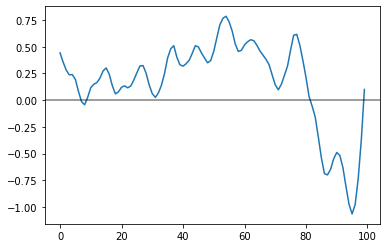

In [99]:
plt.plot(roi_mean_trf.mean(axis=0))
plt.axhline(y=0, color='k', alpha=0.5)

# Tim's code

In [ ]:
# define filter length in seconds, convert to samples
filter_length = 5;
filter_len = filter_length*run_parameters['update_rate'];

# iterate over ROIs to save STRFs and movies
print('Calculating TRFs...')
for roi_id in range(0, roi_data['epoch_response'].shape[0]):
    # initialize strf by trial array (H,W,T,Tr)
    #roi_strf = np.zeros(output_shape+(int(filter_len),int(run_parameters['num_epochs'])));
    roi_trf = np.zeros(filter_len, int(run_parameters['num_epochs']))
    for trial_num in range(0, int(run_parameters['num_epochs'])):
        current_resp = roi_data['epoch_response'][roi_id,trial_num]
        # initialize strf and full time series for update rate of stimulus
        full_t = np.arange(run_parameters['pre_time'],run_parameters['stim_time'] + run_parameters['pre_time'],1 / run_parameters['update_rate'])
        #strf = np.zeros(output_shape+(int(filter_len),))
        trf = np.zeros(int(filter_len))
        # linearly interpolate response to match stimulus timing
        full_resp = np.interp(full_t,roi_data['time_vector'],current_resp)
        resp_mean = np.mean(full_resp)
        resp_var = np.var(full_resp)
        # compute TRF for mean-subtracted stimulus and response; then compile STRF across patches
        n=all_stims.shape[1];
        ext_size=2*n-1
        fsize=2**np.ceil(np.log2(ext_size)).astype('int')
#         for phi in range(0,output_shape[0]):
#             for theta in range(0,output_shape[1]):
#                 #patch_stim = all_stims[phi,theta,:,trial_num];
                
#                 #patch_mean = np.mean(patch_stim)
                
#                 #filter_fft = np.fft.fft(full_resp-resp_mean,fsize) * np.conj(np.fft.fft(patch_stim-patch_mean,fsize));
#                 filter_fft = np.fft.fft(full_resp-resp_mean,fsize) * np.conj(np.fft.fft(vis_stim-vis_mean,fsize));
#                 filt = np.real(np.fft.ifft(filter_fft))[0:int(filter_len)];
#                 trf = np.flip(filt);
#                 strf[phi,theta,:] = trf;
#         # add trial strf to roi_strf array
#         roi_strf[:,:,:,trial_num] = strf;
        
        vis_stim = all_stims[:, trial_num]
        vis_mean = np.mean(vis_stim)
        filter_fft = np.fft.fft(full_resp-resp_mean,fsize) * np.conj(np.fft.fft(vis_stim-vis_mean,fsize));
        filt = np.real(np.fft.ifft(filter_fft))[0:int(filter_len)];
        trf = np.flip(filt);
        roi_srf[:,trial_num] = trf
        
    # compute mean STRF
    #roi_mean_strf = np.mean(roi_strf,3);
    roi_mean_trf = np.mean(roi_trf,1)
    # flip again to have t=0 at beginning
    roi_mean_trf = np.flip(roi_mean_trf,0)
    # calculate std for each patch
    TRF_std = np.std(roi_trf,(0,1))
    # divide by std to generate z-scored STRF
    roi_mean_strf_z = np.zeros(roi_mean_strf.shape)
    for frame in range(0,roi_mean_strf.shape[2]):
        roi_mean_strf_z[:,:,frame] = roi_mean_strf[:,:,frame]/STRF_std
    # print(roi_mean_strf_z[:,:,1])
    # save mean, dc-subtracted (AND a z-scored) STRF
    np.save('/Volumes/TimBigData/Bruker/STRFs/' + experiment_file_name + '/' + experiment_file_name + '-' + roi_set_name + '_' + str(roi_id) + '_STRF.npy', roi_mean_strf)
    np.save('/Volumes/TimBigData/Bruker/STRFs/' + experiment_file_name + '/' + experiment_file_name + '-' + roi_set_name + '_' + str(roi_id) + '_STRFz.npy', roi_mean_strf_z)
    # oversample z-scored STRF in x and y so video looks better
    big_strf=roi_mean_strf_z.repeat(20,axis=0)
    bigger_strf=big_strf.repeat(20,axis=1)
    # oversample z-scored STRF in t so framerate can be reduced
    biggest_strf=bigger_strf.repeat(2,axis=2)
    # convert z-scored STRF to -1 to 1 scale (units are standard deviations)
    low_lim = -3
    high_lim = 3
    new_strf = ((biggest_strf - low_lim) * (2/(high_lim - low_lim))) - 1
    new_strf=np.where(new_strf>1,1,new_strf)
    new_strf=np.where(new_strf<-1,-1,new_strf)
    # make empty rgb array and populate with positive or negative values
    rgb_strf=np.zeros((new_strf.shape+(3,)))
    pos_strf=np.where(new_strf>0,new_strf,0)
    neg_strf=np.where(new_strf<0,new_strf*-1,0)
    rgb_strf[:,:,:,0]=1-(pos_strf*1)-(neg_strf*.3)
    rgb_strf[:,:,:,2]=1-(pos_strf*1)-(neg_strf*0)
    rgb_strf[:,:,:,1]=1-(pos_strf*.3)-(neg_strf*1)
    rgb_strf=np.where(rgb_strf>1,1,rgb_strf)
    # scale rgb_strf to 0-255
    rgb_strf = (rgb_strf*255).astype('uint8')
    # save multicolor video
    fps = 10
    video = cv2.VideoWriter('/Volumes/TimBigData/Bruker/STRFs/' + experiment_file_name + '/' + experiment_file_name + '-' + roi_set_name + '_' + str(roi_id) + '_movie.mp4', cv2.VideoWriter_fourcc(*'mp4v'), float(fps), (new_strf.shape[1],new_strf.shape[0]))
    for frame_count in range(int(new_strf.shape[2]/2)):
        img = rgb_strf[:,:,frame_count,:]
        video.write(img)
    video.release()
print('Done.')